In [34]:
import pandas as pd
import numpy as np
import pandas_ta as ta  
from typing import Tuple
import plotly.graph_objects as go

In [48]:
# Function to calculate the Exponential Moving Average (EMA)
def ema(series, length):
    return series.ewm(span=length, adjust=False).mean()

# Function to calculate the Average True Range (ATR)
def atr(data, length):
    high_low = data['high'] - data['low']
    high_close = np.abs(data['high'] - data['close'].shift(1))
    low_close = np.abs(data['low'] - data['close'].shift(1))
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    return true_range.rolling(window=length).mean()

# Function to calculate Donchian Channel
def calculate_donchian_channel(data, period: int = 20):
    upper = data['high'].rolling(window=period).max()
    lower = data['low'].rolling(window=period).min()
    return upper, lower

# Function to calculate Donchian Channel percentage width
def calculate_donchian_percentage(upper: pd.Series, lower: pd.Series) -> pd.Series:
    middle = (upper + lower) / 2
    return ((upper - lower) / middle) * 100

# Function to calculate CUSUM
def calculate_cusum(data, k=None, window=5, delta=0.8):
    n = len(data)
    S_hi = np.zeros(n)
    S_lo = np.zeros(n)
    price = data['close'].values
    mu = data['close'].rolling(window=window).mean().values  # Using rolling mean as mu
    
    if k is None:
        rolling_sigma = data['close'].rolling(window=window).std()
        k = delta * rolling_sigma.values
        
    for i in range(1, n):
        S_hi[i] = max(0, S_hi[i-1] + (price[i] - mu[i] - k[i]))
        S_lo[i] = max(0, S_lo[i-1] + (-price[i] + mu[i] - k[i]))
        
    return S_hi, S_lo

# Function to process a single timeframe
def process_timeframe(file_path, length, mult, window=5, delta=0.8, h_factor=1.5):
    # Load data
    data = pd.read_csv(file_path)
    data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d')
    data.set_index('datetime', inplace=True)
    
    # Calculate lag and Zero Lag EMA
    lag = (length - 1) // 2
    zlema = ema(data['close'] + (data['close'] - data['close'].shift(lag)), length)
    
    # Calculate volatility bands
    volatility = atr(data, length) * mult
    upper_band = zlema + volatility
    lower_band = zlema - volatility
    
    # Calculate CUSUM
    S_hi, S_lo = calculate_cusum(data, window=window, delta=delta)
    rolling_sigma = data['close'].rolling(window=window).std()
    rolling_h = h_factor * rolling_sigma
    
    # Calculate ADX
    data['ADX'] = ta.adx(high=data['high'], low=data['low'], close=data['close'], length=14)['ADX_14']
    
    # # Calculate Donchian Channels and percentage width
    donchian_upper, donchian_lower = calculate_donchian_channel(data)
    data['donchian_percentage'] = calculate_donchian_percentage(donchian_upper, donchian_lower)
    
    # Initialize trend to -1 (no trend/undefined)
    trend = np.full(len(data), -1)
    
    # Enhanced trend conditions
    bullish_conditions = (
        (data['close'] > upper_band) | 
        (S_hi > rolling_h)
    )
    
    bearish_conditions = (
        (data['close'] < lower_band) |
        (S_lo > rolling_h) 
    )
    
    # consolidation_conditions = (
    #     (data['ADX'] <35) &  # Weak trend
    #     (data['donchian_percentage'] <35) &  # Narrow channel
    #     (data['close'].between(lower_band, upper_band))  # Price within bands
    # )
    
    # Apply conditions
    trend[bullish_conditions] = 1    # Bullish trend
    trend[bearish_conditions] = -1   # Bearish trend
    # trend[consolidation_conditions] = 0  # Consolidation
    
    data['Trend'] = trend
    
    # # Add additional columns for analysis
    # data['ADX'] = data['ADX']
    # data['Donchian_Width'] = data['donchian_percentage']
    
    return data

# Parameters
length = 70
mult = 1.2
timeframes = [60]  # in minutes

# File mapping for timeframes (replace with actual file paths)
timeframe_files = {
    60: 'BTC_2019_2023_1d.csv'
}

# Process all timeframes and store the results
processed_data = {}
for tf, file in timeframe_files.items():
    processed_data[tf] = process_timeframe(file, length, mult)

# Export processed data to CSVs for debugging or further use
for tf, df in processed_data.items():
    output_file = f'ETHUSDT_{tf}m.csv'
    df.to_csv(output_file)
    print(f"Processed data for {tf} minutes saved to {output_file}")

Processed data for 60 minutes saved to ETHUSDT_60m.csv


In [54]:

# Function to calculate the Exponential Moving Average (EMA)
def ema(series, length):
    return series.ewm(span=length, adjust=False).mean()

def compute_hurst_exponent(data, window=100):
    """ Calculate rolling Hurst exponent using Rescaled Range (R/S) Analysis """
    hurst_values = []

    for i in range(len(data) - window):
        segment = data[i:i + window]
        mean_val = np.mean(segment)
        deviation = segment - mean_val
        cumulative_dev = np.cumsum(deviation)

        R = np.ptp(cumulative_dev)  # Peak-to-peak range
        S = np.std(segment)  # Standard deviation

        if S == 0:
            hurst_values.append(np.nan)
        else:
            hurst_values.append(np.log(R / S) / np.log(window))

    hurst_series = pd.Series([np.nan] * window + hurst_values, index=data.index)
    return hurst_series
    
# Function to calculate the Average True Range (ATR)
def atr(data, length):
    high_low = data['high'] - data['low']
    high_close = np.abs(data['high'] - data['close'].shift(1))
    low_close = np.abs(data['low'] - data['close'].shift(1))
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    return true_range.rolling(window=length).mean()

# Function to calculate Donchian Channel
def calculate_donchian_channel(data, period: int = 20):
    upper = data['high'].rolling(window=period).max()
    lower = data['low'].rolling(window=period).min()
    return upper, lower

# Function to calculate Donchian Channel percentage width
def calculate_donchian_percentage(upper: pd.Series, lower: pd.Series) -> pd.Series:
    middle = (upper + lower) / 2
    return ((upper - lower) / middle) * 100

# Function to calculate CUSUM
def calculate_cusum(data, k=None, window=5, delta=0.8):
    n = len(data)
    S_hi = np.zeros(n)
    S_lo = np.zeros(n)
    price = data['close'].values
    mu = data['close'].rolling(window=window).mean().values  # Using rolling mean as mu
    
    if k is None:
        rolling_sigma = data['close'].rolling(window=window).std()
        k = delta * rolling_sigma.values
        
    for i in range(1, n):
        S_hi[i] = max(0, S_hi[i-1] + (price[i] - mu[i] - k[i]))
        S_lo[i] = max(0, S_lo[i-1] + (-price[i] + mu[i] - k[i]))
        
    return S_hi, S_lo

def process_timeframe(file_path, length, mult, window=5, delta=0.8, h_factor=1.5, hurst_window=100):
    # Load data
    data = pd.read_csv(file_path)
    data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d')
    data.set_index('datetime', inplace=True)

    # Compute Hurst Exponent
    data['Hurst'] = compute_hurst_exponent(data['close'], window=hurst_window)

    # Calculate lag and Zero Lag EMA
    lag = (length - 1) // 2
    zlema = ema(data['close'] + (data['close'] - data['close'].shift(lag)), length)

    # Calculate volatility bands
    volatility = atr(data, length) * mult
    upper_band = zlema + volatility
    lower_band = zlema - volatility

    # Calculate CUSUM
    S_hi, S_lo = calculate_cusum(data, window=window, delta=delta)
    rolling_sigma = data['close'].rolling(window=window).std()
    rolling_h = h_factor * rolling_sigma

    # Calculate ADX
    data['ADX'] = ta.adx(high=data['high'], low=data['low'], close=data['close'], length=14)['ADX_14']

    # Calculate Donchian Channels and percentage width
    donchian_upper, donchian_lower = calculate_donchian_channel(data)
    data['donchian_percentage'] = calculate_donchian_percentage(donchian_upper, donchian_lower)

    # Initialize trend to -1 (no trend/undefined)
    trend = np.full(len(data), -1)

    # Enhanced trend conditions with Hurst filtering
    bullish_conditions = (
        (data['close'] > upper_band) | 
        (S_hi > rolling_h) 
        # (data['Hurst'] > 0.5)  # Only buy in trending markets
    )

    bearish_conditions = (
        (data['close'] < lower_band) |
        (S_lo > rolling_h) 
        #(data['Hurst'] > 0.5)  # Only sell in trending markets
    )

    # Apply conditions
    trend[bullish_conditions] = 1    # Bullish trend
    trend[bearish_conditions] = -1   # Bearish trend

    data['Trend'] = trend

    return data

# Parameters
length = 70
mult = 1.2
timeframes = [60]  # in minutes

# File mapping for timeframes (replace with actual file paths)
timeframe_files = {
    60: 'BTC_2019_2023_1d.csv'
}

# Process all timeframes and store the results
processed_data = {}
for tf, file in timeframe_files.items():
    processed_data[tf] = process_timeframe(file, length, mult)

# Export processed data to CSVs for debugging or further use
for tf, df in processed_data.items():
    output_file = f'ETHUSDT_{tf}m.csv'
    df.to_csv(output_file)
    print(f"Processed data for {tf} minutes saved to {output_file}")

Processed data for 60 minutes saved to ETHUSDT_60m.csv


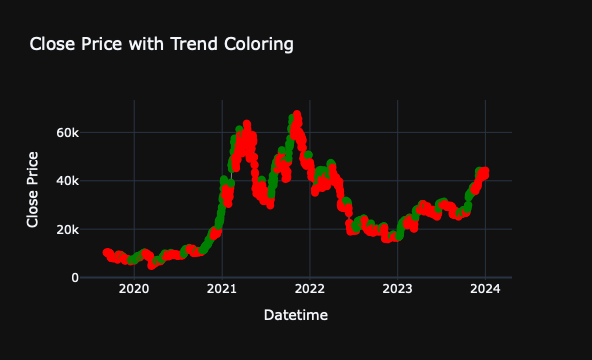

In [56]:
df = pd.read_csv('ETHUSDT_60m.csv')
df.set_index('datetime', inplace=True)

# Assign colors based on trend
df['Color'] = df['Trend'].map({1: 'green', -1: 'red', 0: 'rgba(0, 0, 0, 0)'})

# Create the plot
fig = go.Figure()

# Add scatter trace for the close prices with trend-based coloring
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['close'],
    mode='markers+lines',
    marker=dict(color=df['Color'], size=8),  # Set marker color based on trend
    line=dict(color='gray', width=1),  # Light line for context
    name='Price'
))

# Update layout
fig.update_layout(
    title="Close Price with Trend Coloring",
    xaxis_title="Datetime",
    yaxis_title="Close Price",
    template='plotly_dark',
    showlegend=False
)

# Show the plot
fig.show()


In [58]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score

def compute_metrics(df):
    """
    Compute Trend Direction Accuracy (TDA) and F1-Score for trend predictions.
    
    Parameters:
    df (pd.DataFrame): DataFrame with actual and predicted trends.
    
    Returns:
    dict: TDA (%) and F1-Score.
    """
    # Ensure trends are numeric (-1 for bearish, 0 for neutral, +1 for bullish)
    df['Trend_Actual'] = np.sign(df['close'].diff())  # Actual market trend
    df['Trend_Predicted'] = df['Trend']  # Your model's predicted trend

    # Drop NaN values (first row will have NaN due to differencing)
    df.dropna(inplace=True)

    # Compute Trend Direction Accuracy (TDA)
    correct_predictions = (df['Trend_Predicted'] == df['Trend_Actual']).sum()
    total_predictions = len(df)
    TDA = (correct_predictions / total_predictions) * 100

    # Compute F1-Score
    f1 = f1_score(df['Trend_Actual'], df['Trend_Predicted'], average='weighted')

    return {"TDA (%)": round(TDA, 2), "F1-Score": round(f1, 4)}

# Load processed data (replace 'your_data.csv' with actual file)
df = pd.read_csv("ETHUSDT_60m.csv")
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

# Compute evaluation metrics
metrics = compute_metrics(df)
print(metrics)


{'TDA (%)': 55.65, 'F1-Score': 0.5471}
